# Capstone Project - Establishing a Strategically Located Restaurant Around Manhattan Financial District in NYC

## The Battle of the Neighborhoods (Week 4)

### Applied Data Science Capstone by IBM 

## Table of Contents
- Introduction: business problem
- Data
- Methodology 
- Analysis 
- Results and Discussion 
- Conclusion


## Introduction: business problem

With the aim of finding the optimal location for a potential new restaurant in the city centre, the main aim for this project is providing our stakeholders with all relevant information as to why a given location is strategically better than another. We will prioritize those areas lacking of restaurants, focusing on a specific type of cuisine (japanese) within well served, central areas. 

Based on the criteria we just mentioned, our analysis will therefore help our stakeholders choose a strategic position in New York City, Manhattan.   

## Data

Based on definition of our problem, factors that will influence our decission are:

- Number of existing restaurants in the neighborhood (any type of restaurant);
- Number of and distance of Japanese restaurants from the predefined area;
- Property Price Data. 

With the aim of achieving the abovementioned goals, the following data sources will be used. 
Following data sources will be needed to extract/generate the required information:

- Number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API;
- NYC coordinates and distance parameters obtained through the use of several libraries and, again, Foursquare API; 
- Manhattan Property Price Data obtained from New York City Department of Finance Website. 

## Methodology

Our analysis will be preliminarily focused on determining the best choice in terms of geographic availability and proximity to a predetermined location, with this aim in mind, our first steps in the data analysis process will be addressed by looking at the geographic distribution of similar business ventures over a given area. Following this preliminary step, the analysis will subsequently cover some descriptive statistics helping us to determine where our investors may achieve greater profits by analysing Manhattan property price data. According to these findings, we will conclude our analysis by providing our investors with a well-defined geographic area around which to establish the restaurant based on criteria of availability and affordability. 

In [2]:
#Let's Install the libraries we need
!pip install geopy
!pip install folium
print("Installed!")

     |████████████████████████████████| 93 kB 3.7 MB/s  eta 0:00:01
Installed!


In [1]:
#Importing useful libraries
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import folium
import requests 
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("Imported!")

ModuleNotFoundError: No module named 'folium'

In [64]:
#We run the wget command to obtain the NY data which is stored in a server in .json format

!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


# Data Loading, Exploration and Cleaning

We can now load and explore our data

In [65]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [66]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

We now want to create a variable that includes all the data stored under the key "features"

In [67]:
ny_neighborhoods = newyork_data['features']

In [29]:
ny_neighborhoods[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

We now transform the data into a Pandas DataFrame

In [68]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
ny_districts = pd.DataFrame(columns=column_names)

In [69]:
ny_districts

,Borough,Neighborhood,Latitude,Longitude


In [70]:
for data in ny_neighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_districts = ny_districts.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [71]:
ny_districts.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


As our main purpose is potentially establishing a restaurant within the financial district area, which is located within Manhattan, let's slice the original dataframe and create a new dataframe of the Manhattan data and then we slice it to financial data

In [72]:
manhattan_data = ny_districts[ny_districts['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [73]:
fin_district_data = ny_districts[ny_districts['Neighborhood'] == 'Financial District'].reset_index(drop=True)
fin_district_data

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Financial District,40.707107,-74.010665


To achieve more precision in the address variable we specify the address of the subway line as our main purpose is establishing the restaurant in that area

In [74]:
address = 'New York, NY 10038, United States'

geolocator = Nominatim(user_agent="fin_distr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City, Financial District are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City, Financial District are 40.7127281, -74.0060152.


As can be easily deduced, financial district's original coordinates and the Fulton St. Subway Line ones differ only slightly

We now create a mark on the map signalling the exact geographic point around which we want our restaurant to be established

In [76]:
# create map of FinancialDistrict, Manhattan using latitude and longitude values
map_fin_district = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(fin_district_data['Latitude'], fin_district_data['Longitude'], fin_district_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fin_district)  
    
map_fin_district

Let's narrow-down and highlight the geographic area whereby our stakeholders wish to establish the venue for our restaurant. 

In [77]:
#!pip install folium

import folium

In [78]:
folium.Circle([lat, lng], radius=1000, color='red', fill=False).add_to(map_fin_district)
folium.Marker([lat, lng]).add_to(map_fin_district)
map_fin_district

In [ ]:
FOURSQUARE API SECTION

In [38]:
#Define Foursquare version and credentials: CODE AND OUTPUT HAVE BEEN DELETED FOR PRIVACY CONCERNS


In [106]:
search_query = 'Japanese'
radius = 1000
print(search_query + ' .... OK!')

Japanese .... OK!


In [ ]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url

Send the GET Request and examine the results

In [108]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fce599b76cc650db89f9013'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4b78ac62f964a52047dd2ee3',
    'name': 'Zutto Japanese American Pub',
    'location': {'address': '77 Hudson St',
     'crossStreet': 'Harrison St and Worth St.',
     'lat': 40.7185655837561,
     'lng': -74.00891273768076,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.7185655837561,
       'lng': -74.00891273768076},
      {'label': 'entrance', 'lat': 40.718459, 'lng': -74.009006}],
     'distance': 694,
     'postalCode': '10013',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['77 Hudson St (Harrison St and Worth St.)',
      'New York, NY 10013',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1d1941735',
      'name': 'Noodle House',
      'pluralName': 'Noodle Houses',
      'shortName': 'Noodles',
 

Get relevant part of JSON and transform it into a pandas dataframe

In [109]:
# assign relevant part of JSON to restaurants
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id,location.neighborhood
0,4b78ac62f964a52047dd2ee3,Zutto Japanese American Pub,"[{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...",v-1607358875,False,77 Hudson St,Harrison St and Worth St.,40.718566,-74.008913,"[{'label': 'display', 'lat': 40.7185655837561,...",694,10013,US,New York,NY,United States,"[77 Hudson St (Harrison St and Worth St.), New...",867441,https://www.seamless.com/menu/zutto-77-hudson-...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,42701794,NaN
1,4e6aaea3d164c37bf4b2539d,Sumo Japanese Cuisine,"[{'id': '4bf58dd8d48988d111941735', 'name': 'J...",v-1607358875,False,104 John St,at Cliff St,40.707714,-74.006226,"[{'label': 'display', 'lat': 40.70771408081055...",558,10038,US,New York,NY,United States,"[104 John St (at Cliff St), New York, NY 10038...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f3089ef7150dc431d2d1bd1,Pinklady Cheese Tart,"[{'id': '4bf58dd8d48988d1d0941735', 'name': 'D...",v-1607358875,False,11 Mott St,Worth St,40.713986,-73.998741,"[{'label': 'display', 'lat': 40.713986, 'lng':...",629,10013,US,New York,NY,United States,"[11 Mott St (Worth St), New York, NY 10013, Un...",2139318,https://www.seamless.com/menu/pinklady-cheese-...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN,NaN
3,4b7736b9f964a5206b882ee3,Emperor Japanese Tapas Shabu,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",v-1607358875,False,96 Bowery,btw Hester & Grand,40.717581,-73.995330,"[{'label': 'display', 'lat': 40.71758147589841...",1051,10013,US,New York,NY,United States,"[96 Bowery (btw Hester & Grand), New York, NY ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5464f27c498e2e01c60151af,Kaede Japanese Restaurant,"[{'id': '4bf58dd8d48988d111941735', 'name': 'J...",v-1607358875,False,90 Chambers St,NaN,40.714623,-74.007270,"[{'label': 'display', 'lat': 40.71462286117167...",236,10007,US,New York,NY,United States,"[90 Chambers St, New York, NY 10007, United St...",2398298,https://www.seamless.com/menu/kaede-90-chamber...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN,NaN


In [82]:
dataframe.shape

(50, 25)

Define information of interest and filter dataframe

In [ ]:
#filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
#dataframe_filtered = dataframe.loc[:, filtered_columns]

In [110]:
dataframe.drop(['categories', 'referralId', 'hasPerk', 'location.labeledLatLngs', 'location.cc', 'location.city', 
                             'location.state', 'location.country', 'location.formattedAddress', 'delivery.id', 'delivery.url', 
                             'delivery.provider.name', 'delivery.provider.icon.prefix', 'delivery.provider.icon.sizes', 'delivery.provider.icon.name',
                             'venuePage.id', 'location.neighborhood'], axis=1, inplace=True)

In [111]:
dataframe.head()

,id,name,location.address,location.crossStreet,location.lat,location.lng,location.distance,location.postalCode
0,4b78ac62f964a52047dd2ee3,Zutto Japanese American Pub,77 Hudson St,Harrison St and Worth St.,40.718566,-74.008913,694,10013
1,4e6aaea3d164c37bf4b2539d,Sumo Japanese Cuisine,104 John St,at Cliff St,40.707714,-74.006226,558,10038
2,5f3089ef7150dc431d2d1bd1,Pinklady Cheese Tart,11 Mott St,Worth St,40.713986,-73.998741,629,10013
3,4b7736b9f964a5206b882ee3,Emperor Japanese Tapas Shabu,96 Bowery,btw Hester & Grand,40.717581,-73.995330,1051,10013
4,5464f27c498e2e01c60151af,Kaede Japanese Restaurant,90 Chambers St,NaN,40.714623,-74.007270,236,10007


We produce an even more refined verion of the dataset keeping only the columns that we really need and we also rename it to make it more easily identifiable. 

In [112]:
dataframe.drop(['location.crossStreet', 'location.postalCode'], axis=1, inplace=True)
dataframe.head()

,id,name,location.address,location.lat,location.lng,location.distance
0,4b78ac62f964a52047dd2ee3,Zutto Japanese American Pub,77 Hudson St,40.718566,-74.008913,694
1,4e6aaea3d164c37bf4b2539d,Sumo Japanese Cuisine,104 John St,40.707714,-74.006226,558
2,5f3089ef7150dc431d2d1bd1,Pinklady Cheese Tart,11 Mott St,40.713986,-73.998741,629
3,4b7736b9f964a5206b882ee3,Emperor Japanese Tapas Shabu,96 Bowery,40.717581,-73.995330,1051
4,5464f27c498e2e01c60151af,Kaede Japanese Restaurant,90 Chambers St,40.714623,-74.007270,236


Additionally, as most of the columns name contain a "." as separator, we want to rename these latter as to prevent any ambiguity in later stages of programming

In [113]:
dataframe.rename(columns = {'location.address' : 'address', 'location.lat' : 'lat', 'location.lng' : 'lng', 'location.distance' : 'distance'}, inplace = True)
dataframe.head()

,id,name,address,lat,lng,distance
0,4b78ac62f964a52047dd2ee3,Zutto Japanese American Pub,77 Hudson St,40.718566,-74.008913,694
1,4e6aaea3d164c37bf4b2539d,Sumo Japanese Cuisine,104 John St,40.707714,-74.006226,558
2,5f3089ef7150dc431d2d1bd1,Pinklady Cheese Tart,11 Mott St,40.713986,-73.998741,629
3,4b7736b9f964a5206b882ee3,Emperor Japanese Tapas Shabu,96 Bowery,40.717581,-73.995330,1051
4,5464f27c498e2e01c60151af,Kaede Japanese Restaurant,90 Chambers St,40.714623,-74.007270,236


In [114]:
japanese_df = dataframe
japanese_df.head()

,id,name,address,lat,lng,distance
0,4b78ac62f964a52047dd2ee3,Zutto Japanese American Pub,77 Hudson St,40.718566,-74.008913,694
1,4e6aaea3d164c37bf4b2539d,Sumo Japanese Cuisine,104 John St,40.707714,-74.006226,558
2,5f3089ef7150dc431d2d1bd1,Pinklady Cheese Tart,11 Mott St,40.713986,-73.998741,629
3,4b7736b9f964a5206b882ee3,Emperor Japanese Tapas Shabu,96 Bowery,40.717581,-73.995330,1051
4,5464f27c498e2e01c60151af,Kaede Japanese Restaurant,90 Chambers St,40.714623,-74.007270,236


In [116]:
dataframe.shape

(24, 6)

We now check the dtypes of our dataframe so to make sure that the distance value is an int type

In [93]:
japanese_df.dtypes

id           object
name         object
address      object
lat         float64
lng         float64
distance      int64
dtype: object

Let's visualize the japanese restaurants that are nearby

In [ ]:
japanese_df.name

In [119]:
map_fin_district = folium.Map(location=[40.707107, -74.010665], zoom_start=13) # generate map centred around Fulton St. Subway Line

folium.Circle([40.707107, -74.010665], radius=1000, color='red', fill=False).add_to(map_fin_district)
folium.Marker([40.707107, -74.010665]).add_to(map_fin_district)

# add a red circle marker to represent Fulton St. Subway Line
folium.CircleMarker(
    [40.707107, -74.010665],
    radius=10,
    color='red',
    popup='Fulton St. Subway Line',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_fin_district)

# add the japanese restaurants as blue circle markers
for lat, lng, distance in zip(japanese_df.lat, japanese_df.lng, japanese_df.distance):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=distance,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_fin_district)
        
# display map
map_fin_district

We now look for a list of all the restaurants around the area within a range of 1000 (for strategic reason is not only useful to consider restaurants of the same category 
but other restaurants as well so to offset the availability bias possibility. 

In [37]:
#Define Foursquare version and credentials: CODE AND OUTPUT HAVE BEEN DELETED FOR PRIVACY CONCERNS

In [44]:
address = 'New York, NY 10038, United States'

geolocator = Nominatim(user_agent="foursquare_agent2")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7127281 -74.0060152


In [45]:
categoryId = '4d4b7105d754a06374d81259'
radius = '1000'

In [ ]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}`&ll={},{}&oauth_token={}&v={}&radius=1000&limit={}&categoryId=4d4b7105d754a06374d81259'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT, categoryId)
url 

In [51]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fce52729ff8882095eaaa18'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '5d5f24ec09484500079aee00',
    'name': 'Los Tacos No. 1',
    'location': {'address': '136 Church St',
     'lat': 40.714267,
     'lng': -74.008756,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.714267,
       'lng': -74.008756}],
     'distance': 287,
     'postalCode': '10007',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['136 Church St',
      'New York, NY 10007',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d151941735',
      'name': 'Taco Place',
      'pluralName': 'Taco Places',
      'shortName': 'Tacos',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/taco_',
       'suffix': '.png'},
      'primary': True}],
    'delivery': {'id': '2180700',
     'url': 'https://www.se

In [53]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
allrestaurants_df = json_normalize(venues)
allrestaurants_df.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,location.crossStreet,location.neighborhood,venuePage.id
0,5d5f24ec09484500079aee00,Los Tacos No. 1,"[{'id': '4bf58dd8d48988d151941735', 'name': 'T...",v-1607357042,False,136 Church St,40.714267,-74.008756,"[{'label': 'display', 'lat': 40.714267, 'lng':...",287,10007,US,New York,NY,United States,"[136 Church St, New York, NY 10007, United Sta...",2180700,https://www.seamless.com/menu/los-tacos-no-1-t...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN,NaN,NaN
1,5c6f03f30802d4002c16884c,Joe’s Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1607357042,False,124 Fulton St,40.710178,-74.007769,"[{'label': 'entrance', 'lat': 40.710123, 'lng'...",320,10038,US,New York,NY,United States,"[124 Fulton St (at Nassau St), New York, NY 10...",1090397,https://www.seamless.com/menu/joes-pizza-124-f...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,at Nassau St,NaN,NaN
2,5ab51b6aa4b51b3dc096ed68,Chick-fil-A,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",v-1607357042,False,144 Fulton St,40.710419,-74.008550,"[{'label': 'display', 'lat': 40.7104194, 'lng'...",334,10038,US,New York,NY,United States,"[144 Fulton St, New York, NY 10038, United Sta...",1945160,https://www.seamless.com/menu/chick-fil-a-144-...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN,NaN,NaN
3,5787b68e498efcabbebba4f8,Shake Shack,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",v-1607357042,False,200 Broadway,40.710703,-74.009024,"[{'label': 'display', 'lat': 40.71070286896417...",339,10038,US,New York,NY,United States,"[200 Broadway (at Fulton St), New York, NY 100...",1195030,https://www.seamless.com/menu/shake-shack-200-...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,at Fulton St,NaN,NaN
4,5d754979ea4bf40007c080c4,Tonii’s Fresh Rice Noodle,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1607357042,False,85 Bayard St,40.715671,-73.999074,"[{'label': 'display', 'lat': 40.715671, 'lng':...",671,10013,US,New York,NY,United States,"[85 Bayard St, New York, NY 10013, United States]",2028478,https://www.seamless.com/menu/toniis-fresh-ric...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN,NaN,NaN


In [121]:
allrestaurants_df.drop(['categories', 'referralId', 'hasPerk', 'location.labeledLatLngs', 'location.cc', 'location.city', 
                             'location.state', 'location.country', 'location.formattedAddress', 'delivery.id', 'delivery.url', 
                             'delivery.provider.name','location.crossStreet', 'delivery.provider.icon.prefix', 'delivery.provider.icon.sizes', 'delivery.provider.icon.name',
                             'venuePage.id', 'location.neighborhood'], axis=1, inplace=True)
allrestaurants_df.head()

KeyError: "['categories' 'referralId' 'hasPerk' 'location.labeledLatLngs'\n 'location.cc' 'location.city' 'location.state' 'location.country'\n 'location.formattedAddress' 'delivery.id' 'delivery.url'\n 'delivery.provider.name' 'location.crossStreet'\n 'delivery.provider.icon.prefix' 'delivery.provider.icon.sizes'\n 'delivery.provider.icon.name' 'venuePage.id' 'location.neighborhood'] not found in axis"

In [55]:
allrestaurants_df.shape

(50, 7)

Let's clean up the column names as to remove potential coding ambiguities given by the "." within the column name

In [56]:
allrestaurants_df.rename(columns = {'location.address' : 'address', 'location.lat' : 'lat', 'location.lng' : 'lng', 'location.distance' : 'distance'}, inplace = True)
allrestaurants_df.head()

,id,name,address,lat,lng,distance,location.postalCode
0,5d5f24ec09484500079aee00,Los Tacos No. 1,136 Church St,40.714267,-74.008756,287,10007
1,5c6f03f30802d4002c16884c,Joe’s Pizza,124 Fulton St,40.710178,-74.007769,320,10038
2,5ab51b6aa4b51b3dc096ed68,Chick-fil-A,144 Fulton St,40.710419,-74.008550,334,10038
3,5787b68e498efcabbebba4f8,Shake Shack,200 Broadway,40.710703,-74.009024,339,10038
4,5d754979ea4bf40007c080c4,Tonii’s Fresh Rice Noodle,85 Bayard St,40.715671,-73.999074,671,10013


Let us now filter the dataframe containing all types of restaurants within the given range for those restaurants within the predefined range

In [58]:
all_restaurants_filtered = allrestaurants_df[allrestaurants_df['distance'] <= 1000].reset_index(drop=True)
all_restaurants_filtered.head()

,id,name,address,lat,lng,distance,location.postalCode
0,5d5f24ec09484500079aee00,Los Tacos No. 1,136 Church St,40.714267,-74.008756,287,10007
1,5c6f03f30802d4002c16884c,Joe’s Pizza,124 Fulton St,40.710178,-74.007769,320,10038
2,5ab51b6aa4b51b3dc096ed68,Chick-fil-A,144 Fulton St,40.710419,-74.008550,334,10038
3,5787b68e498efcabbebba4f8,Shake Shack,200 Broadway,40.710703,-74.009024,339,10038
4,5d754979ea4bf40007c080c4,Tonii’s Fresh Rice Noodle,85 Bayard St,40.715671,-73.999074,671,10013


In [122]:
all_restaurants_filtered.shape

(39, 7)

To our initial map_fin_district map we now add other restaurants highlighting them with a different color

Let's now see all the collected restaurants in our area of interest on map, and let's also show Japanese restaurants in different color.

In [123]:
map_fin_district = folium.Map(location=[40.707107, -74.010665], zoom_start=13) # generate map centred around Fulton St. Subway Line

folium.Circle([40.707107, -74.010665], radius=1000, color='red', fill=False).add_to(map_fin_district)
folium.Marker([40.707107, -74.010665]).add_to(map_fin_district)

# add a red circle marker to represent Fulton St. Subway Line
folium.CircleMarker(
    [40.707107, -74.010665],
    radius=10,
    color='red',
    popup='Fulton St. Subway Line',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_fin_district)

#Generic restaurants as green circle markers 

for lat, lng, distance in zip(all_restaurants_filtered.lat, all_restaurants_filtered.lng, all_restaurants_filtered.distance):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=distance,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(map_fin_district)
    
# add the japanese restaurants as blue circle markers
for lat, lng, distance in zip(japanese_df.lat, japanese_df.lng, japanese_df.distance):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=distance,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_fin_district)
        
# display map
map_fin_district

### Preliminary Analysis

In [125]:
import numpy as np

print('Total number of restaurants in our predefined area:', len(all_restaurants_filtered))
print('Total number of Japanese restaurants in our predefined area:', len(japanese_df))
print('Percentage of Japanese restaurants in our predefined area: {:.2f}%'.format(len(japanese_df) / len(all_restaurants_filtered) * 100))

Total number of restaurants in our predefined area: 39
Total number of Japanese restaurants in our predefined area: 24
Percentage of Japanese restaurants in our predefined area: 61.54%


### Our preliminary analysis clearly shows a strong concentration of japanese restaurant within our specific range. We therefore deepen our analysis so to take into account other fundamental factors concerning the affordability of a potential commercial venue around the area. 

With the aim of analyzing NYC property price data and, based on the geographical distribution of the venues in our predefined area, we want to analyze property prices as to determine the more convenient area to buy or rent a property to establish our restaurant

### Data wrangling Section

In [5]:
# The code was removed by Watson Studio for sharing.

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,10009,0,5,1633,6440,1900,2,C2,6625000,7/19/2017 0:00
1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,10009,0,10,2272,6794,1913,2,C4,3936272,9/23/2016 0:00
2,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,10009,0,6,2369,4615,1900,2,C2,8000000,11/17/2016 0:00
3,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,210 AVENUE B,10009,0,8,1750,4226,1920,2,C4,3192840,9/23/2016 0:00
4,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,629 EAST 5TH STREET,10009,0,24,4489,18523,1920,2,D9,16232000,11/7/2016 0:00


In [5]:
print(df_data_1.dtypes)

NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
ZIP CODE                           int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                         int64
SALE DATE                         object
dtype: object


We first check whether there are some null values in the column associated with the propery sale price

In [7]:
print("number of NaN values for the column SALE PRICE :", df_data_1['SALE PRICE'].isnull().sum())

number of NaN values for the column SALE PRICE : 0


## Exploratory data analysis and Conclusions

### According to our visual analysis, the area most deficient in restaurants, especially japanese, was that located further west of our area. Specifically, after some research online we've found that this neighborhood is "Battery Park". We therefore want to compare the property prices between Battery Park and Financial District as a commercial facility in the former neighborhood may be way cheaper to buy. 

We filter our dataset so to include the postal codes of the two neighborhoods Financial District and Battery Park

In [9]:
property_type = df_data_1["BUILDING CLASS CATEGORY"].value_counts().to_frame()
property_type.index.name = 'Propery Type'
property_type.head(10)

,BUILDING CLASS CATEGORY
Propery Type,
01 ONE FAMILY DWELLINGS,14210
02 TWO FAMILY DWELLINGS,12863
10 COOPS - ELEVATOR APARTMENTS,11845
13 CONDOS - ELEVATOR APARTMENTS,10794
03 THREE FAMILY DWELLINGS,3586
07 RENTALS - WALKUP APARTMENTS,2732
09 COOPS - WALKUP APARTMENTS,2563
04 TAX CLASS 1 CONDOS,1434
15 CONDOS - 2-10 UNIT RESIDENTIAL,1205


As shown in the dataframe we just obtained, many of the facility types do not meet the needs for our business venture, we therefore consider dropping some of them. However, with the aim of deepening our analysis and narrow down our data even more, we first produce some boxplots comparing business class category and property price

We first create a list of the postal codes we want to keep, but first we run a "shape" command and then rename the "zip code" column which contains a space

In [20]:
df_data_1.shape

(69087, 17)

In [9]:
df_data_1.rename(columns = {'ZIP CODE' : 'zip_code'}, inplace = True)

In [10]:
postal_codes = [10282, 10280, 10004, 10005, 10006, 10038]

In [11]:
property_data= df_data_1[df_data_1.zip_code.isin(postal_codes)]
property_data.shape

(722, 17)

In [ ]:
property_data.drop(['NEIGHBORHOOD'], axis=1, inplace=True)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

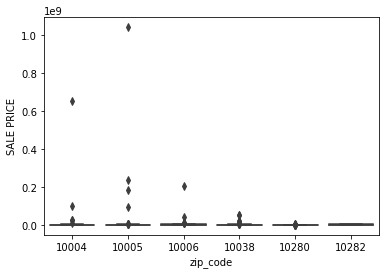

In [13]:
sns.boxplot(x = "zip_code", y = "SALE PRICE", data = property_data)

According to the boxplots above, we can see that the biggest outliers seem to occur within the zipcodes related to the Financial district, while the last two seem to present more balanced price ranges. 

In [35]:
property_data.groupby('zip_code').mean()

,BLOCK,LOT,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
zip_code,,,,,,,
10004,19.158537,1754.280488,0.024390,1.292683,1678.536585,2.048780,1.126281e+07
10005,32.034682,1231.023121,0.219653,5.757225,1848.728324,2.057803,1.053303e+07
10006,20.962963,1267.098765,1.962963,2.956790,1983.543210,2.049383,4.370808e+06
10038,94.762431,625.618785,0.342541,0.906077,1878.613260,2.099448,2.070025e+06
10280,16.000000,4300.681034,0.000000,1.000000,1061.827586,2.017241,1.029132e+06
10282,16.000000,4347.250000,0.000000,1.000000,2000.000000,2.000000,2.188501e+06


## Conclusion

Following a merely visual analysis of the venues belonging our category of interest within the predefined area, we have prelimianrily determined the geographical boundaries that have allowed us to perform additional analysis concerning property prices in Manhattan and, more precisely, around the area that could allow our stakeholders to make a strategically better choice in terms of both affordability and proximity of the commercial venue. 
As can we clearly see from the dataframe above, average prices differ widely across zipcodes. Specifically, one of the zipcodes (10280) concerning our area of interest, which has been shown before to lack in japanese restaurants, shows lower sale prices as compared to most of the others). We could therefore conclude that renting or even buying a venue in the area bounded by the zipcode "10280" may constitute a more efficient and strategic choice. 